In [53]:
using JuMP, Ipopt, Plots, LaTeXStrings

In [54]:
include("params.jl");
S = S * 10

35000

Using a time step $\Delta=1\, hr$ and a forecast length of $T=24\,hr$, the cost is just a sum of the decision variables at each time step

In [55]:
S*αꜝ/Cᵢ

0.01950750750750751

In [56]:
model = Model(Ipopt.Optimizer);

# Optimization Variables
@variable(model, ϕ_h_gas[1:Nₜ] .>= 0)
@variable(model, ϕ_h_elect[1:Nₜ] .>= 0)
@variable(model, ϕ_c_elect[1:Nₜ] .>= 0)
@variable(model, Tᵢₘₐₓ .>= Tᵢ[1:Nₜ] .>= Tᵢₘᵢₙ)
@variable(model, Tw[1:Nₜ, 1:Nₓ])

# Initial Conditions
@constraint(model, Tw[1,:] == Twᵒ)
@constraint(model, Tᵢ[1] == Tᵢᵒ)

# Dynamic Constraints
forcingfunc(k) = 1/Cᵢ * (ϕ_h_gas[k]+ϕ_h_elect[k]-ϕ_c_elect[k]-S*αꜝ*(Tᵢ[k]-Tw[k,1]))
    # Implicit (Backward) Euler in time
@constraint(model, [k in 1:Nₜ-1], Tᵢ[k+1] == Tᵢ[k] + Δt * forcingfunc(k+1))
    # Centered Difference in space
@constraint(model, [k in 1:Nₜ-1, j in 2:Nₓ-1], Tw[k+1,j] == 
                Tw[k,j] + Δt*β/(Δx)^2 * (Tw[k+1,j+1]-2*Tw[k+1,j]+Tw[k+1,j-1]))
# Boundary Conditions (O(Δx²) forward and backward diff. first derivatives at the tips)
@constraint(model, [k in 2:Nₜ], 0 == αꜝ*(Tᵢ[k]-Tw[k,1]) + κ/(2*Δx)*(-3*Tw[k,1]+4*Tw[k,2]-Tw[k,3]))
@constraint(model, [k in 2:Nₜ], 0 == αꜝꜝ*(Tw[k,Nₓ]-Tₐ[k]) + κ/(2*Δx)*(3*Tw[k,Nₓ]-4*Tw[k,Nₓ-1]+Tw[k,Nₓ-2]))

# Cost Function
cost(ϕ_h_gas, ϕ_h_elect, ϕ_c_elect) = C_gas * sum(ϕ_h_gas) + 
C_elec_onPeak * sum(ϕ_h_elect[1:13] + ϕ_c_elect[1:13]) + 
C_elec_offPeak * sum(ϕ_h_elect[14:24] + ϕ_c_elect[14:24]);
@objective(model, Min, cost(ϕ_h_gas, ϕ_h_elect, ϕ_c_elect));
#set_silent(model)


0.1 ϕ_h_gas[1] + 0.1 ϕ_h_gas[2] + 0.1 ϕ_h_gas[3] + 0.1 ϕ_h_gas[4] + 0.1 ϕ_h_gas[5] + 0.1 ϕ_h_gas[6] + 0.1 ϕ_h_gas[7] + 0.1 ϕ_h_gas[8] + 0.1 ϕ_h_gas[9] + 0.1 ϕ_h_gas[10] + 0.1 ϕ_h_gas[11] + 0.1 ϕ_h_gas[12] + 0.1 ϕ_h_gas[13] + 0.1 ϕ_h_gas[14] + 0.1 ϕ_h_gas[15] + 0.1 ϕ_h_gas[16] + 0.1 ϕ_h_gas[17] + 0.1 ϕ_h_gas[18] + 0.1 ϕ_h_gas[19] + 0.1 ϕ_h_gas[20] + 0.1 ϕ_h_gas[21] + 0.1 ϕ_h_gas[22] + 0.1 ϕ_h_gas[23] + 0.1 ϕ_h_gas[24] + 0.12 ϕ_h_elect[1] + 0.12 ϕ_c_elect[1] + 0.12 ϕ_h_elect[2] + 0.12 ϕ_c_elect[2] + 0.12 ϕ_h_elect[3] + 0.12 ϕ_c_elect[3] + [[...12 terms omitted...]] + 0.12 ϕ_h_elect[10] + 0.12 ϕ_c_elect[10] + 0.12 ϕ_h_elect[11] + 0.12 ϕ_c_elect[11] + 0.12 ϕ_h_elect[12] + 0.12 ϕ_c_elect[12] + 0.12 ϕ_h_elect[13] + 0.12 ϕ_c_elect[13] + 0.04 ϕ_h_elect[14] + 0.04 ϕ_c_elect[14] + 0.04 ϕ_h_elect[15] + 0.04 ϕ_c_elect[15] + 0.04 ϕ_h_elect[16] + 0.04 ϕ_c_elect[16] + 0.04 ϕ_h_elect[17] + 0.04 ϕ_c_elect[17] + 0.04 ϕ_h_elect[18] + 0.04 ϕ_c_elect[18] + 0.04 ϕ_h_elect[19] + 0.04 ϕ_c_elect[19] + 0.04 ϕ_h

In [57]:
optimize!(model);

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      488
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      192
                     variables with only lower bounds:       72
                variables with lower and upper bounds:       24
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.3999936e-02 1.00e+01 9.60e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [58]:
Tᵢ_t, ϕ_h_gas_t, ϕ_h_elect_t, ϕ_c_elect_t, Tw_t = value.(Tᵢ), value.(ϕ_h_gas), value.(ϕ_h_elect), value.(ϕ_c_elect), value.(Tw);

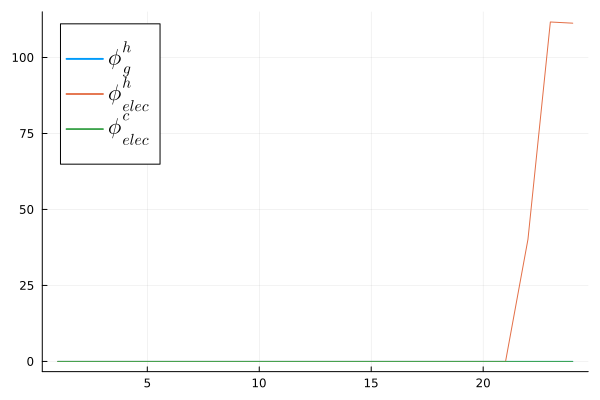

In [59]:
plot(ϕ_h_gas_t, label = L"$\phi_g^h$")
plot!(ϕ_h_elect_t, label = L"$\phi_{elec}^h$")
plot!(ϕ_c_elect_t, label = L"$\phi_{elec}^c$", legendfontsize=15)

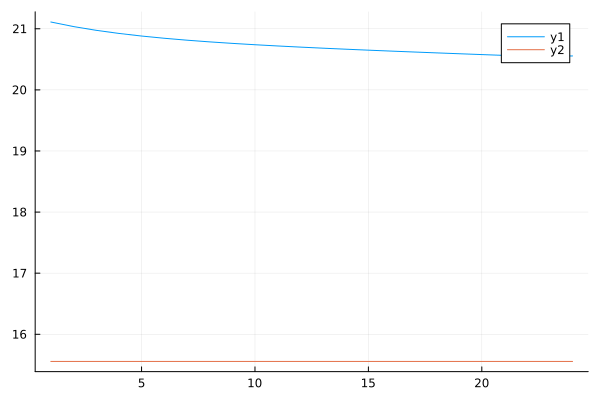

In [60]:
plot(Tᵢ_t)
plot!(Tₐ)

In [61]:
Tᵢ_t

24-element Vector{Float64}:
 21.11111111111111
 21.036226963662155
 20.97495496540117
 20.924122114837434
 20.88137477843433
 20.84493206528225
 20.81342769891915
 20.785803647765345
 20.76123548729981
 20.739078207136856
  ⋮
 20.634834289385672
 20.62006947098832
 20.605691039308788
 20.591624207425266
 20.57781001950362
 20.564201994828718
 20.555555351354958
 20.55555535132434
 20.555555350007474

In [62]:
Tw_t

24×4 Matrix{Float64}:
 10.0     10.0     10.0     10.0
 17.1975  11.9199  11.4421  14.5695
 17.834   13.3911  12.626   14.8207
 18.3183  14.5285  13.5824  15.0274
 18.69    15.4131  14.3476  15.1948
 18.9768  16.1034  14.9558  15.3289
 19.1984  16.6432  15.4374  15.4355
 19.3697  17.0656  15.8176  15.52
 19.5018  17.3962  16.1171  15.5867
 19.6032  17.6548  16.3526  15.6393
  ⋮                         
 19.8533  18.36    17.0065  15.7863
 19.8632  18.4024  17.0476  15.7957
 19.8686  18.4342  17.0791  15.8029
 19.8705  18.4576  17.1031  15.8085
 19.8697  18.4744  17.1211  15.8127
 19.8666  18.486   17.1343  15.8159
 19.865   18.4942  17.1441  15.8183
 19.8679  18.5011  17.1514  15.82
 19.8703  18.5067  17.157   15.8213

In [63]:
k = 1
 αꜝꜝ*(Tw_t[k,Nₓ]-Tₐ[k]) + κ/(2*Δx)*(3*Tw_t[k,Nₓ]-4*Tw_t[k,Nₓ-1]+Tw_t[k,Nₓ-2])


-0.06444444444444444

In [64]:
k=2
value(1/Cᵢ*S*αꜝ*(Tᵢ[k]-Tw[k,1]))

0.07488414745432892